## TP6: Clustering and Classifying Text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395103 sha256=961a563121a26ab5f1d0359fbce3e8339f503e66e4c3795c4f2f62e688bff97a
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [ ]:
pip install mpld3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

In [ ]:
# Let's use the same comcastcomplaints dataset we use for classification
data = pd.read_csv ('/content/drive/MyDrive/data/comcast_consumeraffairs_complaints.csv')

# selecting required columns and rows
data = data [['text']]
data = data [pd.notnull (data ['text'])]

# let's do the clustering for just 300 rows. It's easier to interpret
data_sample = data.sample (300)

In [ ]:
data.head()

,text
0,I used to love Comcast. Until all these consta...
1,I'm so over Comcast! The worst internet provid...
2,If I could give them a negative star or no sta...
3,I've had the worst experiences so far since in...
4,Check your contract when you sign up for Comca...


In [ ]:
data.shape

(5629, 1)

In [ ]:
data_sample.shape

(300, 1)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# remove unwanted symbol
data_sample ['text'] = data_sample ['text'].str.replace ('XXXX', "")

# convert dataframe to list
complaints = data_sample ['text'].tolist ()

# create the rank of documents - I will use it later
# using it as ground truth labels for clustering evaluation metrics like homogeneity.
ranks = []
for i in range (1, len (complaints) + 1):
    ranks.append (i)

# stop words
stopwords = nltk.corpus.stopwords.words ('english')

# load 'stemmer'
stemmer = SnowballStemmer ('english')

# functions for sentence tokenizer, to remove tokens and raw # pucntuation
def tokenize_and_stem (text):
    tokens = [word for sent in nltk.sent_tokenize (text) for word in nltk.word_tokenize (sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search ('[a-zA-Z]', token):
            filtered_tokens.append (token)
    stems = [stemmer.stem (t) for t in filtered_tokens]
    return stems

def tokenize_only (text):
    tokens =[word.lower () for sent in nltk.sent_tokenize (text) for word
            in nltk.word_tokenize (sent)]

    filtered_tokens = []
    for token in tokens:
        if re.search ('[a-zA-Z]', token):
            filtered_tokens.append (token)
    return filtered_tokens

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer (max_df = 0.8, max_features = 200000, min_df = 0.2,
                                   use_idf = True, tokenizer = tokenize_and_stem, ngram_range = (1, 3))
# fit the vectiorizer to data
tfidf_matrix = tfidf_vectorizer.fit_transform (complaints)
terms = tfidf_vectorizer.get_feature_names_out ()
print (tfidf_matrix.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(300, 151)


## K-Means

In [ ]:
# import Kmeans
from sklearn.cluster import KMeans

# define numbers of clusters
num_clusters = 6

# running clustreing algorithm
km = KMeans (n_clusters = num_clusters)
km.fit (tfidf_matrix)

# final clusters
clusters = km.labels_.tolist ()
complaints_data = {'rank': ranks, 'complaints': complaints, 'cluster': clusters}
frame = pd.DataFrame (complaints_data, index = [clusters], columns = ['rank', 'cluster'])

# number of docs per cluster
frame ['cluster'].value_counts ()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    92
3    62
5    50
2    38
0    36
4    22
Name: cluster, dtype: int64

In [ ]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
    allwords_stemmed = tokenize_and_stem (i)
    totalvocab_stemmed.extend (allwords_stemmed)
    allwords_tokenized = tokenize_only (i)
    totalvocab_tokenized.extend (allwords_tokenized)
vocab_frame = pd.DataFrame ({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

# sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort ()[:, ::-1]
for i in range (num_clusters):
    print ("Cluster %d words:" % i, end = "")
    for ind in order_centroids [i, :6]:
        print (' %s' % vocab_frame.loc [terms [ind].split (' ')].values.tolist ()[0][0].encode ('utf-8', 'ignore'), end = ',')
        print ()

Cluster 0 words: b'was',
 b'my',
 b'i',
 b'that',
 b'told',
 b'install',
Cluster 1 words: b'was',
 b'my',
 b'that',
 b'call',
 b'me',
 b'he',
Cluster 2 words: b'we',
 b'our',
 b'they',
 b'of',
 b'have',
 b'is',
Cluster 3 words: b'you',
 b'they',
 b'of',
 b'have',
 b'are',
 b'get',
Cluster 4 words: b'box',
 b'cable',
 b'my',
 b'have',
 b'they',
 b'that',
Cluster 5 words: b'my',
 b'is',
 b'have',
 b'bills',
 b'they',
 b'that',


In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, adjusted_rand_score, v_measure_score

# Assuming you have true labels for your data
true_labels = ranks

# Calculate homogeneity score
homogeneity = homogeneity_score(true_labels, km.labels_)
print("Homogeneity Score:", homogeneity)

# Calculate completeness score
completeness = completeness_score(true_labels, km.labels_[:300])
print("Completeness Score:", completeness)

# Calculate completeness score
Vmeasure = v_measure_score(true_labels, km.labels_[:300])
print("V-measure:", Vmeasure)

silhouette_avg = silhouette_score(tfidf_matrix, clusters)
print("Silhouette Score:", silhouette_avg)

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(true_labels, km.labels_[:300])
print("Adjusted Rand Index:", ari)


Homogeneity Score: 0.29711793509848905
Completeness Score: 1.0000000000000002
V-measure: 0.45812015555228464
Silhouette Score: 0.030315323658913512
Adjusted Rand Index: 0.0


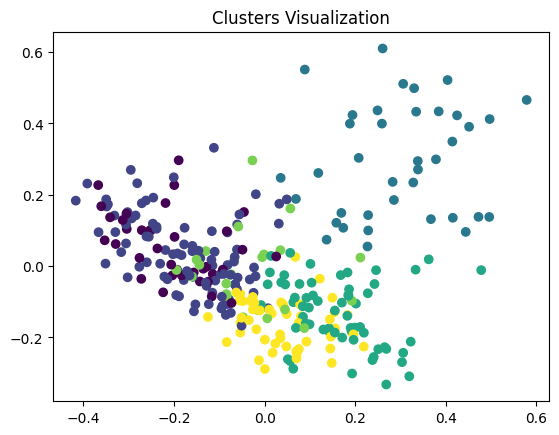

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters Visualization')
plt.show()

# CLARANS (Clustering Large Applications based on RANdomized Search)

is a clustering algorithm that is suitable for large datasets. Unlike KMeans, CLARANS uses a sampling technique to find clusters in the dataset. The main advantage of CLARANS is that it is less sensitive to the initialization of centroids, making it more robust in certain scenarios.

In [ ]:
from pyclustering.cluster import cluster_visualizer, clarans
from pyclustering.cluster.clarans import clarans as clarans_instance

# Number of clusters
num_clusters = 6

# Set the number of local minima of cost function to discover
num_local_minima = 2

# Set the maximum number of neighbors
max_neighbors = 3

# Create CLARANS instance
clarans_instance = clarans_instance(tfidf_matrix.toarray(), num_clusters, num_local_minima, max_neighbors)

# Run CLARANS algorithm
clarans_instance.process()

# Get clustering results
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

# Flatten the clusters for each document
flat_clusters = [-1] * len(complaints)
for cluster_idx, cluster in enumerate(clusters):
    for document_idx in cluster:
        flat_clusters[document_idx] = cluster_idx

# Assuming you have true labels for your data
true_labels = ranks

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score

# Assuming you have true labels for your data
true_labels = ranks

# Calculate Homogeneity
homogeneity = homogeneity_score(true_labels, flat_clusters)
print("Homogeneity Score:", homogeneity)

# Calculate Completeness
completeness = completeness_score(true_labels, flat_clusters)
print("Completeness Score:", completeness)

# Calculate V-measure
vmeasure = v_measure_score(true_labels, flat_clusters)
print("V-measure:", vmeasure)

silhouette_avg = silhouette_score(tfidf_matrix, flat_clusters)
print("Silhouette Score:", silhouette_avg)

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(true_labels, flat_clusters)
print("Adjusted Rand Index:", ari)


Homogeneity Score: 0.24347891482489334
Completeness Score: 1.0000000000000002
V-measure: 0.3916092374741715
Silhouette Score: 0.007271021219800563
Adjusted Rand Index: 0.0


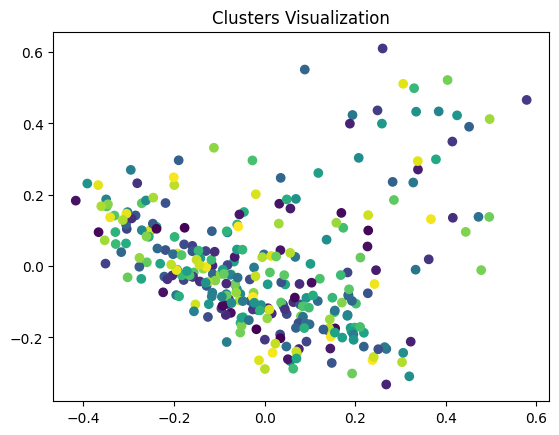

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten the list of lists into a single list
flat_clusters = [item for sublist in clusters for item in sublist]

# Scatter plot with flattened clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=flat_clusters, cmap='viridis')
plt.title('Clusters Visualization')
plt.show()

In [ ]:
import pandas as pd

# Données du tableau
data = {
    '': ['Homogeneity ', 'Completeness ', 'V-measure', 'Silhouette', 'Adjusted-Rand-Index'],
    'K-Means': [0.30, 1.00, 0.46, 0.03, 0.0],
    'CLARANS': [0.21, 1.0, 0.35, 0.011, 0.0]
}

# Création d'un DataFrame à partir des données
df = pd.DataFrame(data)

# Affichage du DataFrame
df


,,K-Means,CLARANS
0,Homogeneity,0.30,0.210
1,Completeness,1.00,1.000
2,V-measure,0.46,0.350
3,Silhouette,0.03,0.011
4,Adjusted-Rand-Index,0.00,0.000


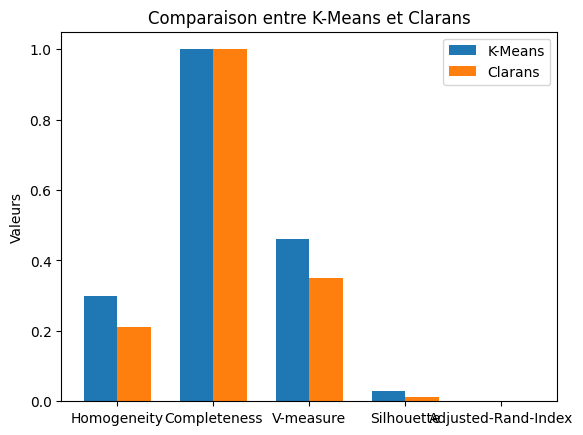

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Données
labels = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette', 'Adjusted-Rand-Index']
kMeans_values = [0.30, 1.00, 0.46, 0.03, 0.00]
Clarans_values = [0.21, 1.00, 0.35, 0.011, 0.00]

# Position des barres sur l'axe des x
x = np.arange(len(labels))

# Largeur des barres
width = 0.35

# Créer le graphique à barres
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, kMeans_values, width, label='K-Means')
bar2 = ax.bar(x + width/2, Clarans_values, width, label='Clarans')

# Ajouter des étiquettes, un titre, une légende, etc.
ax.set_ylabel('Valeurs')
ax.set_title('Comparaison entre K-Means et Clarans')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Afficher le graphique
plt.show()


Homogeneity: elle mesure à quel point les membres d'un même cluster partagent la même étiquette de classe. ou 1=> le cas parfaite


Completeness: évaluer à quel point tous les points appartenant à une même classe particulière sont regroupés dans le même cluster ou 1=> parfaite

V-measure: combine à la fois l'homogénéité et la complétude ou 1=> parfaite

Silhouette: à quel point chaque point d'un cluster est similaire aux points du même cluster par rapport à d'autres clusters.
    Une valeur proche de 1 indique que le point est bien ajusté à son propre cluster et mal ajusté aux clusters voisins.
    Une valeur proche de -1 indique qu'un point est mal ajusté à son propre cluster et bien ajusté aux clusters voisins.
    Une valeur proche de 0 indique un chevauchement significatif des clusters.

Adjusted-Rand-Index:  d'évaluation de la similarité entre deux partitions (groupements)
    1 signifie une correspondance parfaite entre les partitions.
    0 signifie que les partitions sont équivalentes au hasard.
    -1 signifie une discordance totale entre les partitions.